In [ ]:
!pip install dask[dataframe]
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
df=pd.read_csv('malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.type.value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [ ]:
# Plotting Wordcloud

In [ ]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

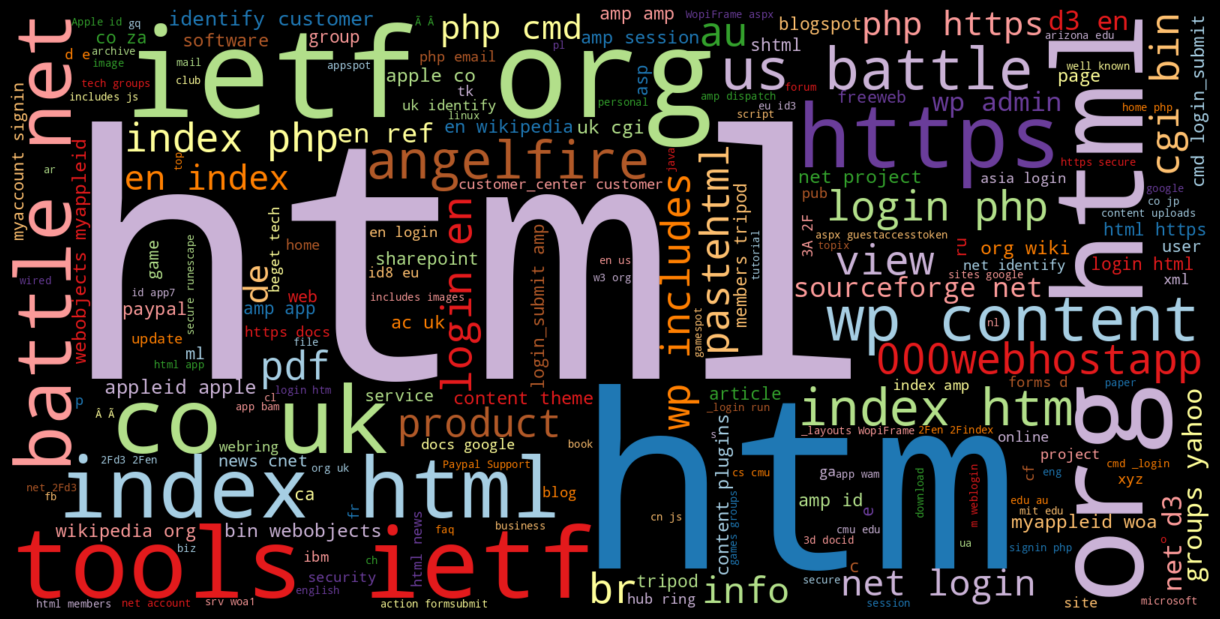

In [ ]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

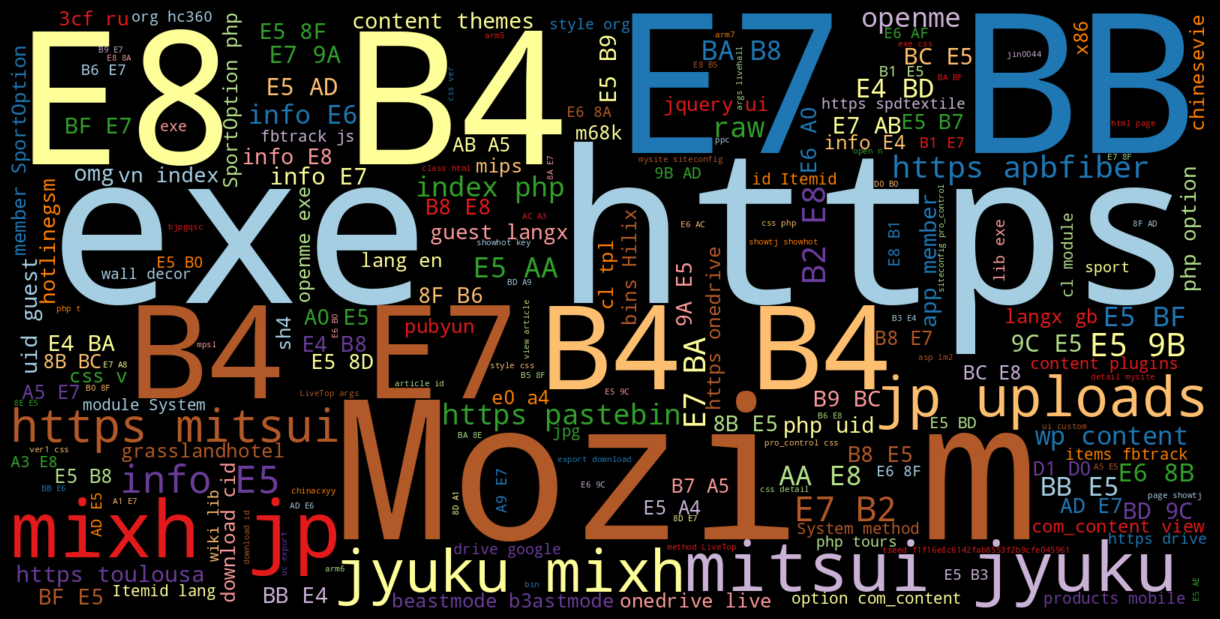

In [ ]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

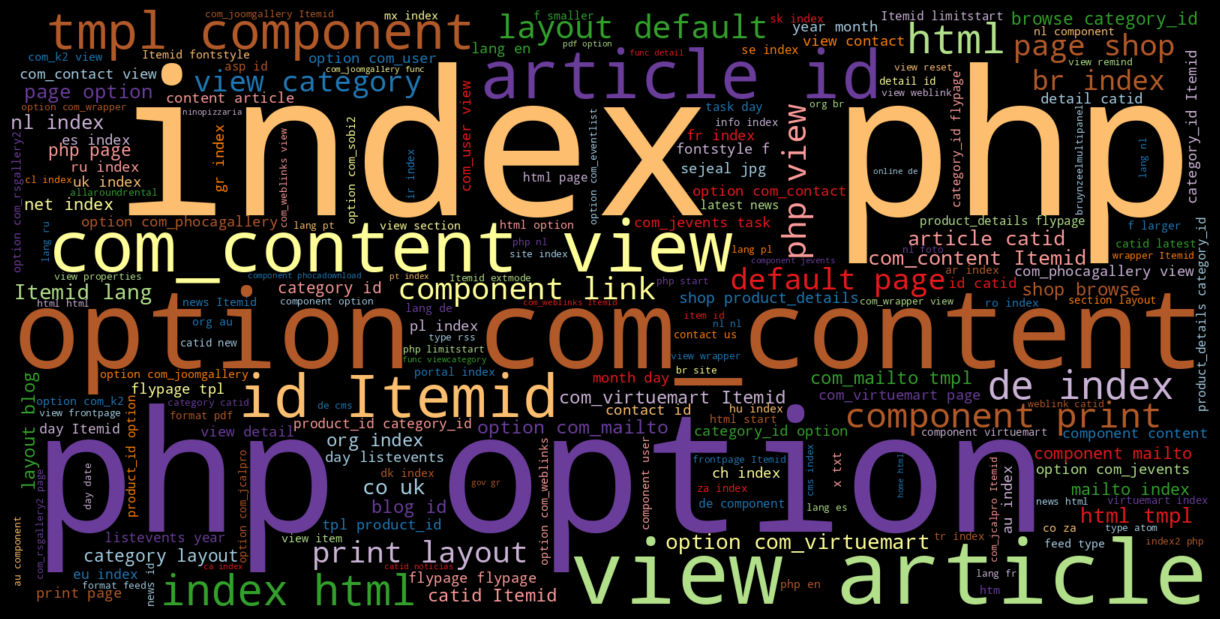

In [ ]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

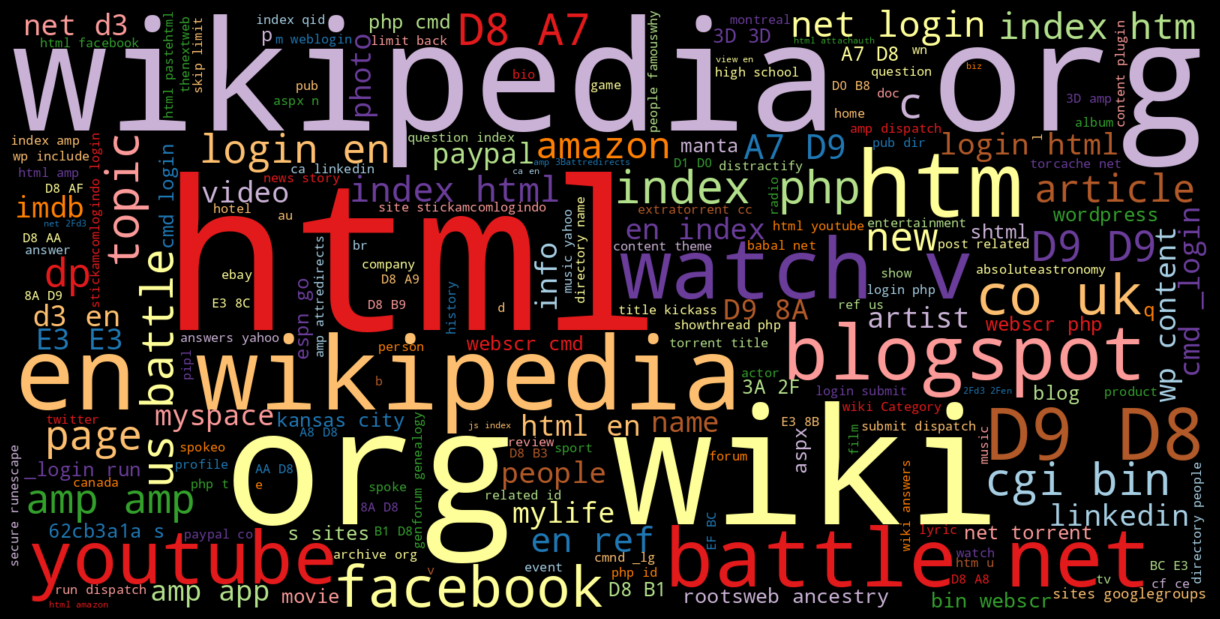

In [ ]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Feature Engineering

In [ ]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [ ]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [ ]:
!pip install googlesearch-python

In [ ]:
from googlesearch import search

In [ ]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [ ]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,type_code,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,hostname_length,sus_url,count-digits,count-letters,fd_length,tld_length,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,3,0,0,0,0,0,0,0,...,0,0,0,13,0,-1,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,2,0,0,0,0,...,0,0,1,29,5,-1,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,3,0,0,0,0,...,0,0,1,25,7,-1,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,1,0,1,0,0,0,1,...,21,0,7,63,9,2,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,0,0,1,0,0,0,1,...,23,0,22,199,9,3,0,1,1,2


In [ ]:
import re
from urllib.parse import urlparse

# Function to count occurrences of 'www'
def count_www(url):
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

# Function to count occurrences of '@'
def count_atrate(url):
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))

# Function to count the number of directories in the URL path
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

# Function to count the number of embedded domains (double slashes '//' in path)
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))

# Function to check if the URL uses a shortening service
def shortening_service(url):
    match = re.search(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      r'tr\.im|link\.zip\.net',
                      url)
    return 1 if match else 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [ ]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [ ]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,type_code,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,hostname_length,sus_url,count-digits,count-letters,fd_length,tld_length,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,3,0,0,0,0,0,0,0,...,0,0,0,13,0,-1,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,2,0,0,0,0,...,0,0,1,29,5,-1,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,3,0,0,0,0,...,0,0,1,25,7,-1,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,1,0,1,0,0,0,1,...,21,0,7,63,9,2,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,0,0,1,0,0,0,1,...,23,0,22,199,9,3,0,1,1,2


In [ ]:
!pip install tld

In [ ]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [ ]:
df = df.drop("tld", axis=1)

In [ ]:
df.columns

Index(['url', 'type', 'type_code', 'count-www', 'count@', 'count_dir',
       'count_embed_domian', 'short_url', 'count-https', 'count-http',
       'count%', 'count?', 'count-', 'count=', 'url_length', 'hostname_length',
       'sus_url', 'count-digits', 'count-letters', 'fd_length', 'tld_length',
       'use_of_ip', 'abnormal_url', 'google_index', 'count.'],
      dtype='object')

In [ ]:
df['type'].value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [ ]:
# EDA
# 1. Distribution of use_of_ip

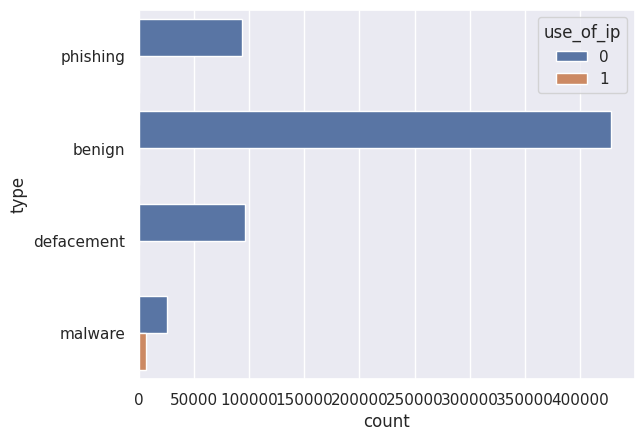

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

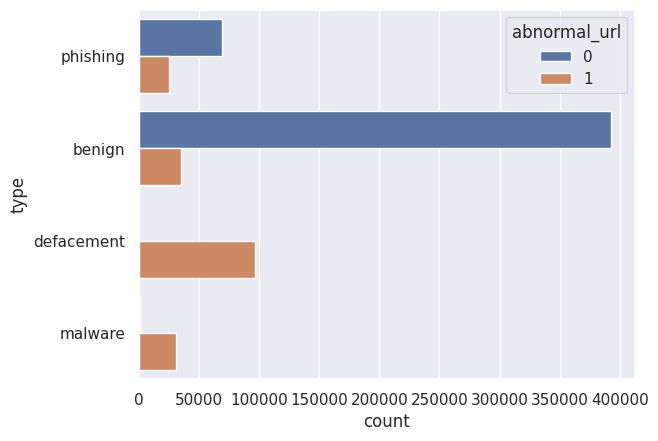

In [ ]:
# 2. Distribution of abnormal url
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

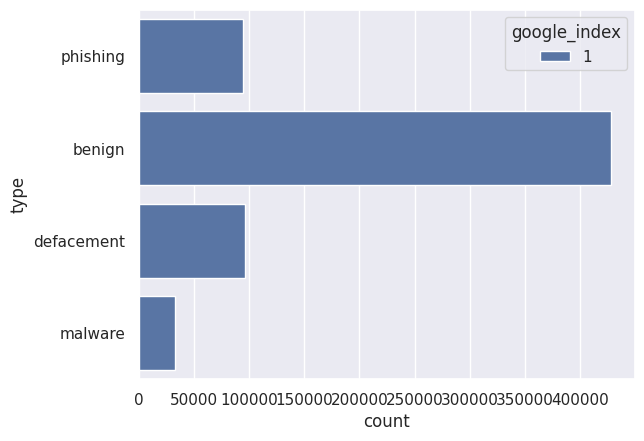

In [ ]:
# 3. Distribution of Google Index
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

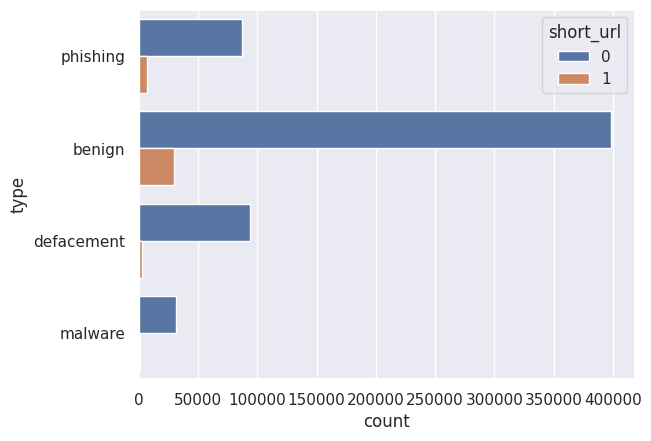

In [ ]:
# 4. Distribution of Shorl URL
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

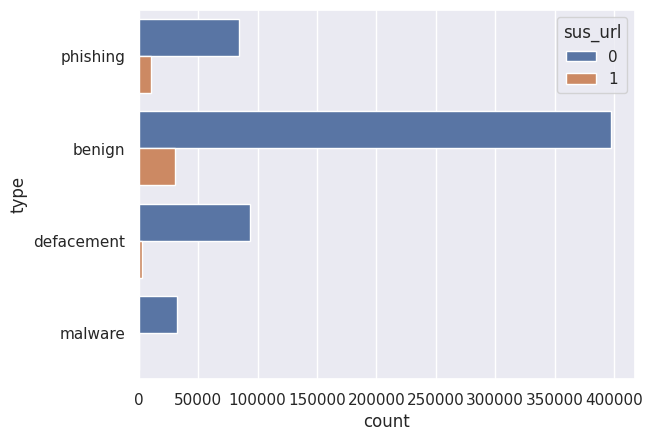

In [ ]:
# 5. Distribution of Suspicious URL
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

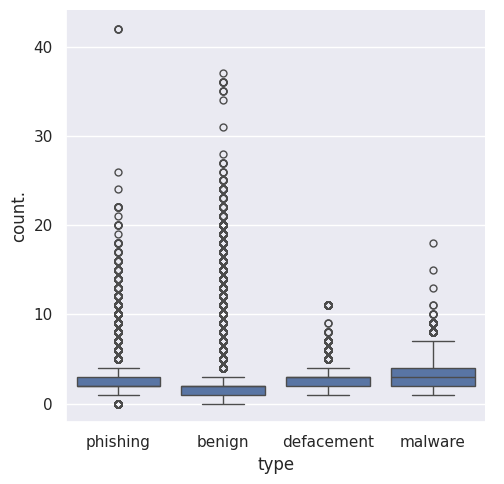

In [ ]:
# 6. Distribution of count of [.] dot
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

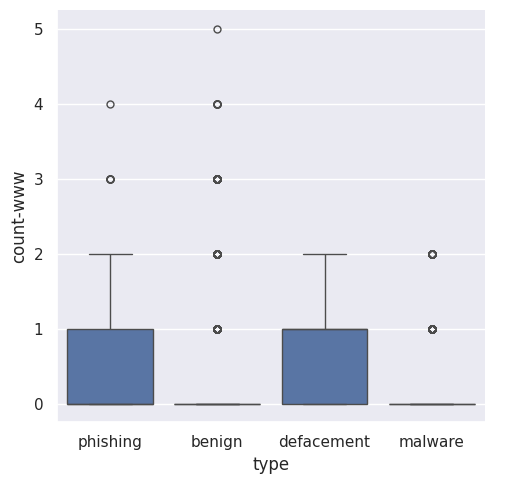

In [ ]:
# 7. Distribution of count-www
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

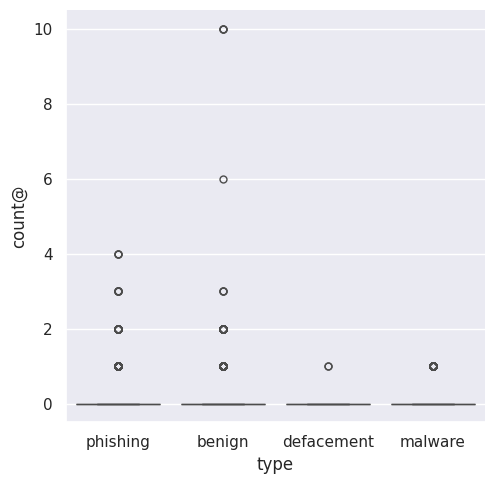

In [ ]:
# 8. Distribution of count@
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count@", kind="box", data=df)

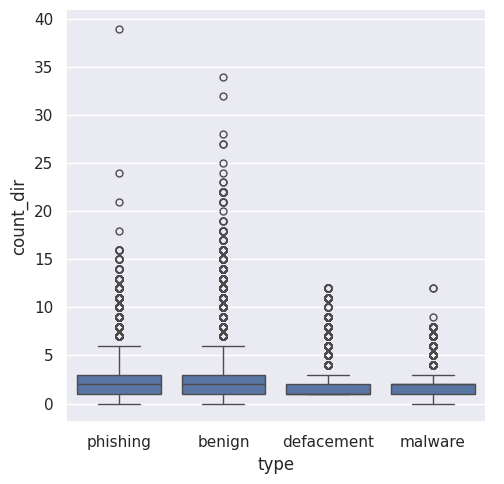

In [ ]:
# 9. Distribution of count_dir
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

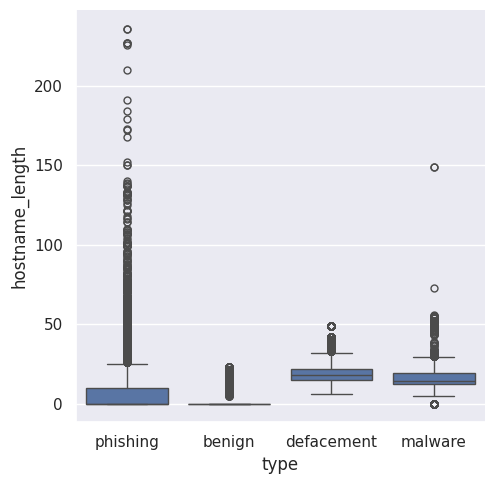

In [ ]:
# 10. Distribution of hostname length
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

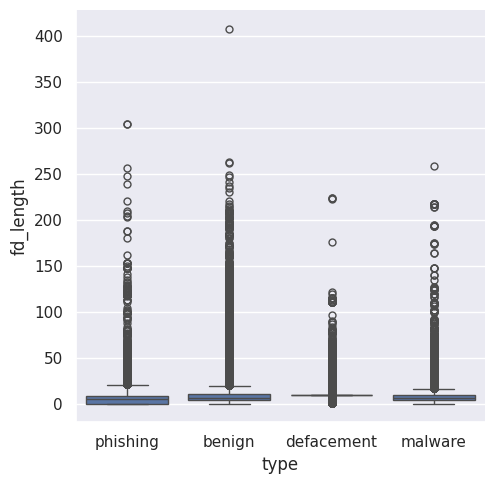

In [ ]:
# 11. Distribution of first directory length
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

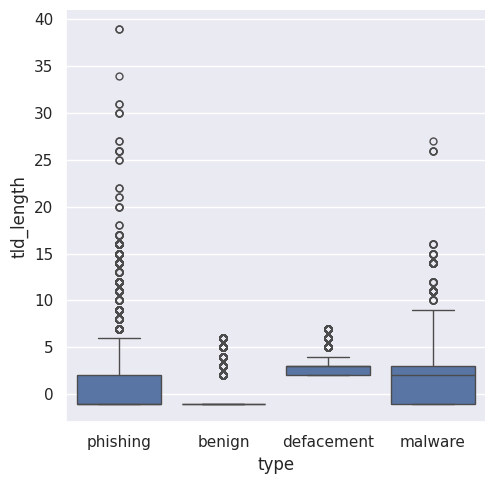

In [ ]:
# 12. Distribution of top-level domain length
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

In [ ]:
# Target Encoding
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

,count
type_code,
0,428103
1,96457
3,94111
2,32520


In [ ]:
# Creation of Feature & Target
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [ ]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [ ]:
# Model Building
# 1. Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score  # Import necessary metrics

# Train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_rf, target_names=['benign', 'defacement', 'phishing', 'malware']))

# Calculate and print accuracy score
score = accuracy_score(y_test, y_pred_rf)  # Use accuracy_score directly
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.97      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


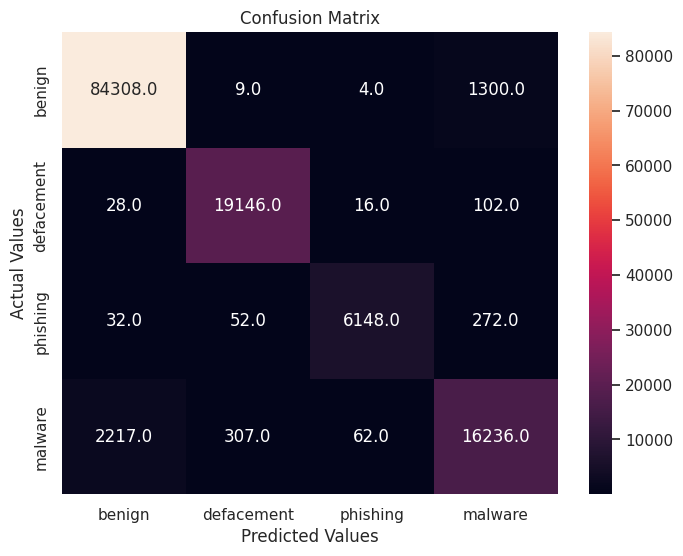

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

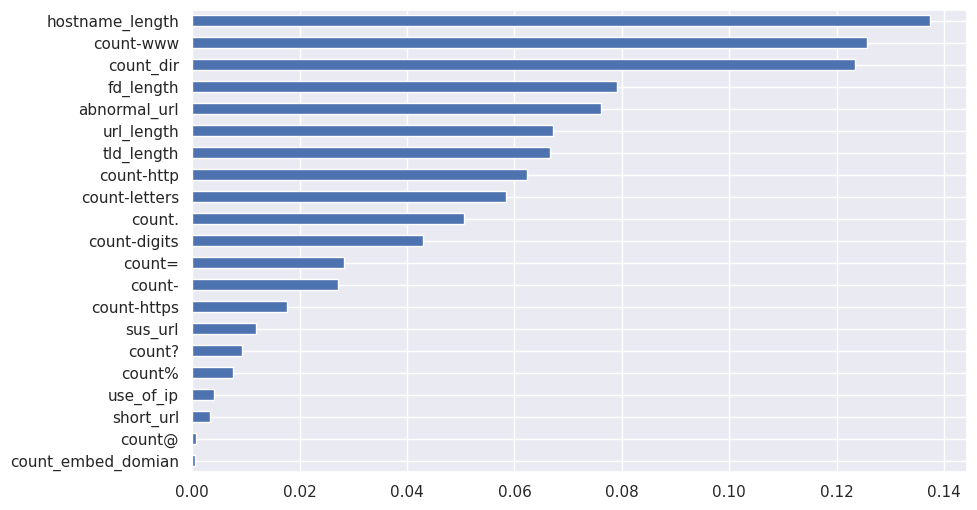

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [ ]:
# 2. Light GBM Classifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score  # Make sure to import metrics

# Initialize the LGBMClassifier
lgb = LGBMClassifier(objective='multiclass', boosting_type='gbdt', n_jobs=5, random_state=5)

# Fit the model
LGB_C = lgb.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = LGB_C.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_lgb, target_names=['benign', 'defacement', 'phishing', 'malware']))

# Calculate and print accuracy score
score = accuracy_score(y_test, y_pred_lgb)  # Use accuracy_score directly
print("accuracy:   %0.3f" % score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 21
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.90      0.83      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.959


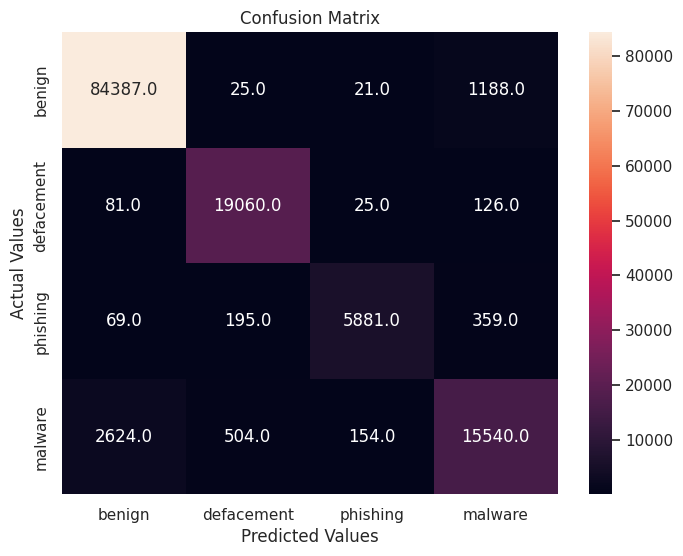

In [ ]:
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

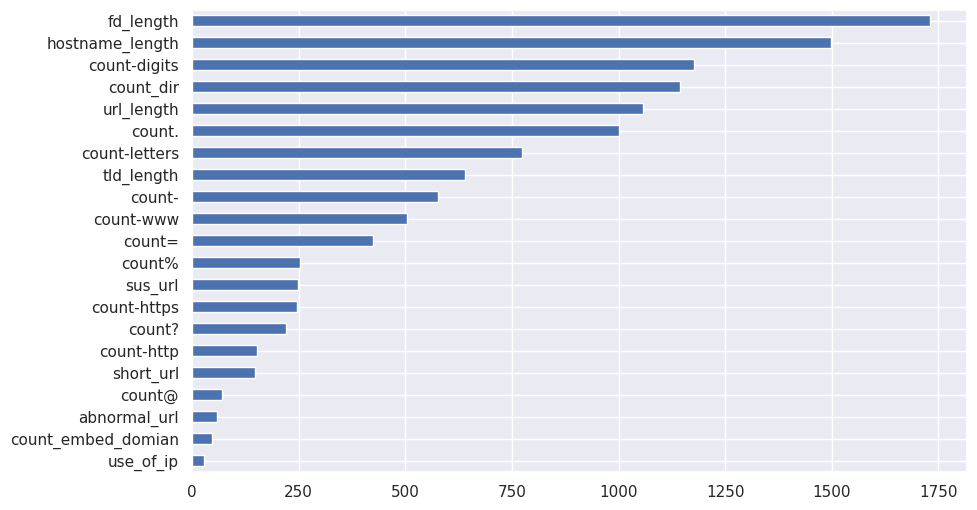

In [ ]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [ ]:
# 3. XGboost Classifier
import xgboost as xgb  # Make sure to import XGBoost
from sklearn.metrics import classification_report, accuracy_score  # Import necessary metrics

# Initialize the XGBClassifier
xgb_c = xgb.XGBClassifier(n_estimators=100)

# Fit the model
xgb_c.fit(X_train, y_train)

# Predict on the test set
y_pred_x = xgb_c.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_x, target_names=['benign', 'defacement', 'phishing', 'malware']))

# Calculate and print accuracy score
score = accuracy_score(y_test, y_pred_x)  # Use accuracy_score directly
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.98      0.91      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.962


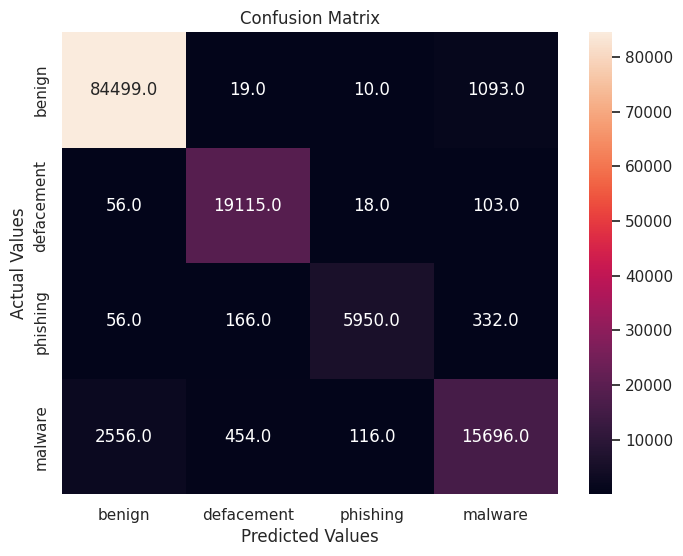

In [ ]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

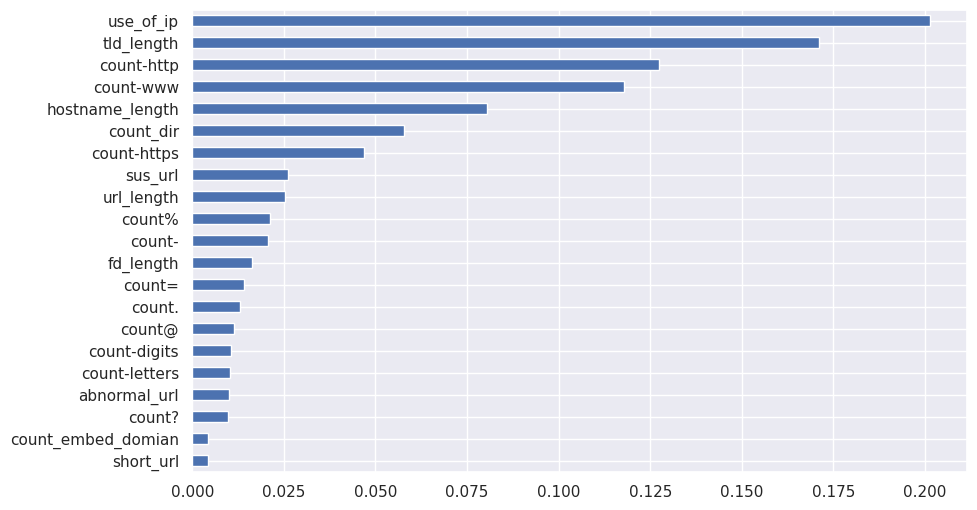

In [ ]:
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [ ]:
# Prediction
def main(url):

    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))

    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))

    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))

    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)

    status.append(tld_length(tld))




    return status

In [ ]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))



    pred = lgb.predict(features_test)
    if int(pred[0]) == 0:

        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:

        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res

    elif int(pred[0]) == 3.0:

        res="MALWARE"
        return res

In [ ]:
urls = ['titaniumcorporate.co.za','en.wikipedia.org/wiki/North_Dakota']
for url in urls:
     print(get_prediction_from_url(url))

MALWARE
SAFE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Importing necessary libraries
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import ssl
import socket

# Function to scrape website and print attributes
# Updated function to ensure URL includes the scheme
def analyze_and_print_website(url):
    try:
        # Check if the URL has a scheme, if not, prepend 'https://'
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        # Request the webpage
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract and print title
        title = soup.title.string if soup.title else "No Title"
        print(f"Title: {title}")

        # Extract and print meta description and keywords
        meta_description = soup.find('meta', attrs={'name': 'description'})
        meta_description = meta_description['content'] if meta_description else "No Description"
        print(f"Meta Description: {meta_description}")

        meta_keywords = soup.find('meta', attrs={'name': 'keywords'})
        meta_keywords = meta_keywords['content'] if meta_keywords else "No Keywords"
        print(f"Meta Keywords: {meta_keywords}")

        # Extract and print headers (h1, h2, h3)
        headers = {
            'h1': [h1.text.strip() for h1 in soup.find_all('h1')],
            'h2': [h2.text.strip() for h2 in soup.find_all('h2')],
            'h3': [h3.text.strip() for h3 in soup.find_all('h3')],
        }
        print(f"H1 Headers: {headers['h1']}")
        print(f"H2 Headers: {headers['h2']}")
        print(f"H3 Headers: {headers['h3']}")

        # Extract and print first 5 paragraphs
        paragraphs = [p.text.strip() for p in soup.find_all('p')]
        print(f"Paragraphs: {paragraphs[:5]}")  # Print first 5 paragraphs

        # Extract and print first 5 links
        links = [a['href'] for a in soup.find_all('a', href=True)]
        print(f"Links: {links[:5]}")  # Print first 5 links

        # Check for SSL certificate validity
        try:
            parsed_url = urlparse(url)
            hostname = parsed_url.hostname
            context = ssl.create_default_context()
            with socket.create_connection((hostname, 443)) as conn:
                with context.wrap_socket(conn, server_hostname=hostname) as ssl_conn:
                    ssl_info = ssl_conn.getpeercert()
                    print("SSL Certificate: Valid")
        except Exception as e:
            print("SSL Certificate: Invalid or Not Available")

    except requests.exceptions.RequestException as e:
        print(f"Failed to analyze {url}: {str(e)}")

# Example usage: Replace with your list of URLs
websites_to_analyze = [
    "titaniumcorporate.co.za",
    "en.wikipedia.org/wiki/North_Dakota"
]

# Loop through websites and print their attributes
for website in websites_to_analyze:
    print(f"\nAnalyzing: {website}")
    analyze_and_print_website(website)
    print("-" * 50)


Analyzing: titaniumcorporate.co.za
Failed to analyze https://titaniumcorporate.co.za: HTTPSConnectionPool(host='titaniumcorporate.co.za', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'titaniumcorporate.co.za'. (_ssl.c:1006)")))
--------------------------------------------------

Analyzing: en.wikipedia.org/wiki/North_Dakota
Title: North Dakota - Wikipedia
Meta Description: No Description
Meta Keywords: No Keywords
H1 Headers: ['North Dakota']
H2 Headers: ['Contents', 'History', 'Geography', 'Demographics', 'Economy', 'Culture', 'Media', 'Education', 'Emergency services', 'Transportation', 'Law and government', 'Notable people', 'See also', 'Notes', 'References', 'Bibliography', 'External links']
H3 Headers: ['Pre-colonial history', 'European exploration and colonization', 'Settlement and statehood', '20th century', '21st century', 

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin
import socket
import ssl

# Function to fetch detailed information about a URL
def analyze_detailed_website_info(url):
    try:
        # Prepend https:// if not already present
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        # Make the request and capture response, ignoring SSL errors
        response = requests.get(url, allow_redirects=True, verify=False)  # verify=False skips SSL certificate validation
        soup = BeautifulSoup(response.text, 'html.parser')

        # HTTP Response Information
        print(f"\nAnalyzing: {url}")
        print(f"HTTP Response:")
        print(f"Final URL: {response.url}")
        print(f"Serving IP Address: {socket.gethostbyname(urlparse(response.url).hostname)}")
        print(f"Status code: {response.status_code}")
        print(f"Body length: {len(response.content) / 1024:.2f} KB")
        print(f"Body SHA-256: {response.content.hex()}")  # Hex encoded body content (mimicking SHA-256)

        # Printing headers
        print("\nHeaders:")
        for key, value in response.headers.items():
            print(f"{key.lower()}: {value}")

        # HTML Info
        print("\nHTML Info:")
        title = soup.title.string if soup.title else "No Title"
        print(f"Title: {title}")

        # Meta Tags
        print("\nMeta Tags:")
        for meta in soup.find_all('meta'):
            if meta.get('name'):
                print(f"{meta.get('name')}: {meta.get('content')}")

        # Print the redirection chain (if any)
        print("\nRedirection chain:")
        for resp in response.history:
            print(f"{resp.url}")

        # SSL Certificate details (if using HTTPS)
        if url.startswith('https://'):
            try:
                hostname = urlparse(response.url).hostname
                context = ssl.create_default_context()
                with socket.create_connection((hostname, 443)) as conn:
                    with context.wrap_socket(conn, server_hostname=hostname) as ssl_conn:
                        ssl_info = ssl_conn.getpeercert()
                        print("\nSSL Certificate: Valid")
            except Exception as ssl_error:
                print("\nSSL Certificate: Invalid or Not Available")

    except requests.exceptions.RequestException as e:
        print(f"Failed to analyze {url}: {str(e)}")


# Example usage: Replace with the URLs you want to analyze
websites_to_analyze = [
    "https://www.google.com",
    "https://titaniumcorporate.co.za"
]

# Analyze each website and print the information
for website in websites_to_analyze:
    analyze_detailed_website_info(website)
    print("-" * 50)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Analyzing: https://www.google.com
HTTP Response:
Final URL: https://www.google.com/
Serving IP Address: 142.251.2.103
Status code: 200
Body length: 18.34 KB
Body SHA-256: 3c21646f63747970652068746d6c3e3c68746d6c206974656d73636f70653d2222206974656d747970653d22687474703a2f2f736368656d612e6f72672f5765625061676522206c616e673d22656e223e3c686561643e3c6d65746120636f6e74656e743d225365617263682074686520776f726c64277320696e666f726d6174696f6e2c20696e636c7564696e672077656270616765732c20696d616765732c20766964656f7320616e64206d6f72652e20476f6f676c6520686173206d616e79207370656369616c20666561747572657320746f2068656c7020796f752066696e642065786163746c79207768617420796f75277265206c6f6f6b696e6720666f722e22206e616d653d226465736372697074696f6e223e3c6d65746120636f6e74656e743d226e6f6f64702c2022206e616d653d22726f626f7473223e3c6d65746120636f6e74656e743d22746578742f68746d6c3b20636861727365743d5554462d382220687474702d65717569763d22436f6e74656e742d54797065223e3c6d65746120636f6e74656e743d222f696d616765732f6272616e

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'titaniumcorporate.co.za'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Analyzing: https://titaniumcorporate.co.za
HTTP Response:
Final URL: https://titaniumcorporate.co.za/
Serving IP Address: 41.203.18.177
Status code: 200
Body length: 2.30 KB
Body SHA-256: 3c686561643e0a3c21444f43545950452068746d6c205055424c494320222d2f2f5733432f2f445444205848544d4c20312e30205374726963742f2f454e220a22687474703a2f2f7777772e77332e6f72672f54522f7868746d6c312f4454442f7868746d6c312d7374726963742e647464223e0a3c68746d6c20786d6c6e733d22687474703a2f2f7777772e77332e6f72672f313939392f7868746d6c22206c616e673d22656e2220786d6c3a6c616e673d22656e223e0a0a20203c736372697074207372633d2268747470733a2f2f63646e6a732e636c6f7564666c6172652e636f6d2f616a61782f6c6962732f747269616e676c6966792f312e302e312f747269616e676c6966792e6d696e2e6a73223e3c2f7363726970743e0a0a20203c7363726970743e0a20202866756e6374696f6e2829207b0a20202020646f63756d656e742e6164644576656e744c697374656e65722827444f4d436f6e74656e744c6f61646564272c2066756e6374696f6e2829207b0a0a20202020766172207061747465726e203d20547269616e676c69667

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'titaniumcorporate.co.za'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


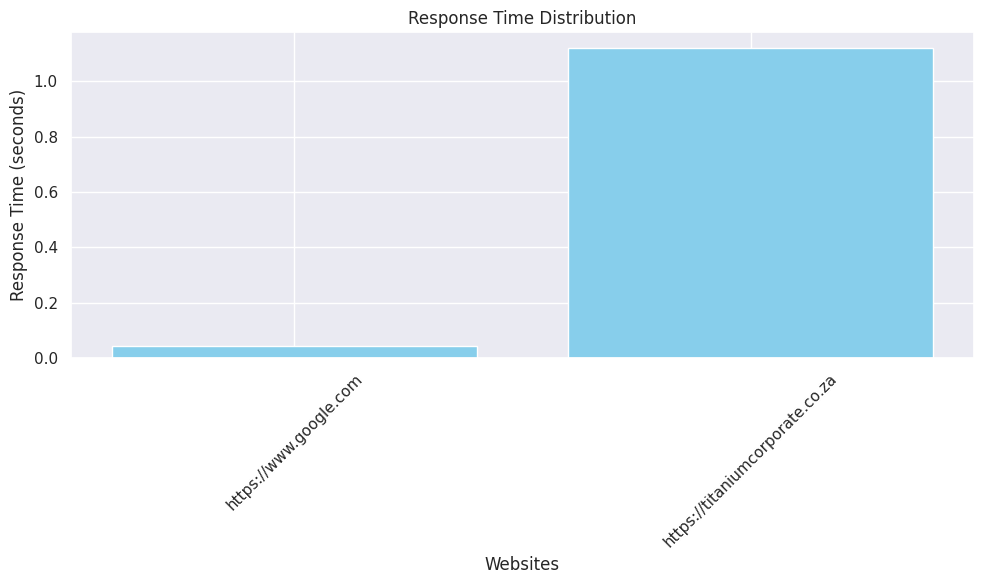

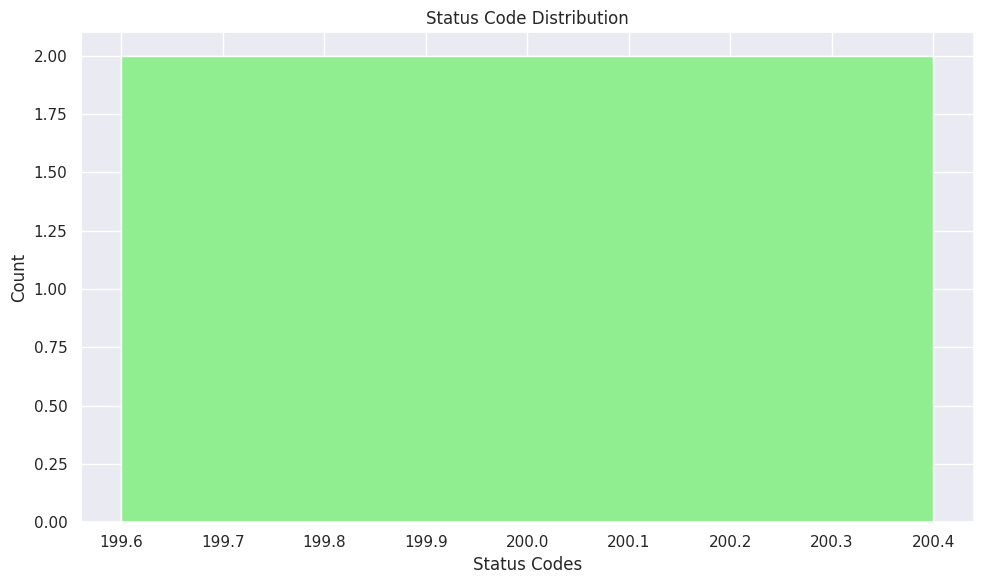

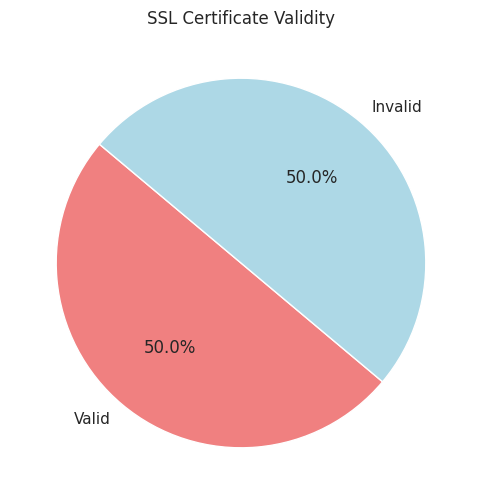

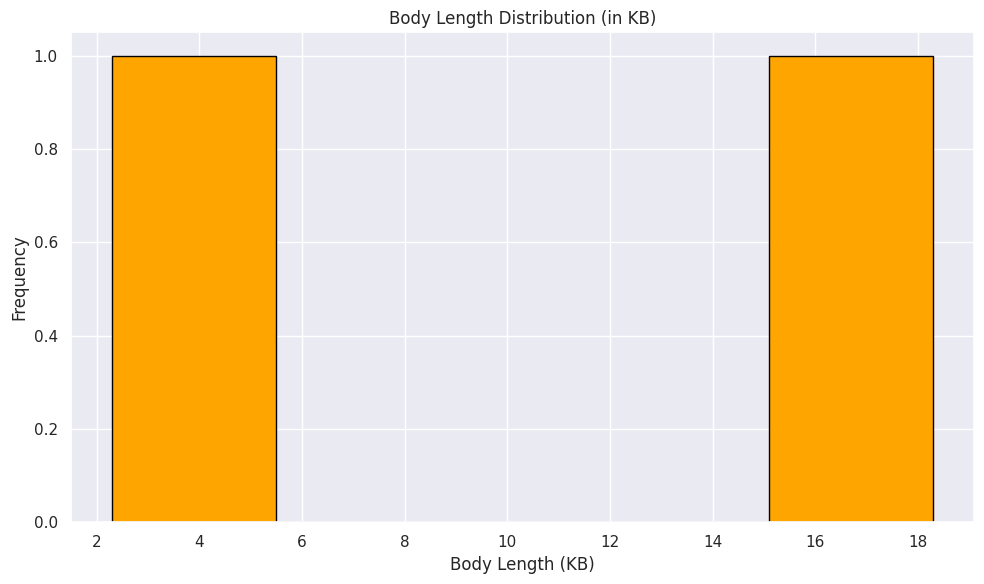

In [ ]:
import matplotlib.pyplot as plt
import requests
import ssl
import socket
from urllib.parse import urlparse
import time
import numpy as np

# Data storage for graphing
response_times = []
status_codes = []
ssl_validity = {'valid': 0, 'invalid': 0}
body_lengths = []

# Function to analyze websites and collect data for graphs
def analyze_website_for_graphs(url):
    try:
        # Prepend https:// if not already present
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        # Measure the response time
        start_time = time.time()
        response = requests.get(url, allow_redirects=True, verify=False)  # Bypass SSL validation
        response_time = time.time() - start_time
        response_times.append(response_time)

        # Collect status codes
        status_codes.append(response.status_code)

        # Collect body length
        body_lengths.append(len(response.content) / 1024)  # Size in KB

        # SSL Certificate validation
        if url.startswith('https://'):
            try:
                hostname = urlparse(response.url).hostname
                context = ssl.create_default_context()
                with socket.create_connection((hostname, 443)) as conn:
                    with context.wrap_socket(conn, server_hostname=hostname) as ssl_conn:
                        ssl_info = ssl_conn.getpeercert()
                        ssl_validity['valid'] += 1
            except Exception as ssl_error:
                ssl_validity['invalid'] += 1
        else:
            ssl_validity['invalid'] += 1

    except requests.exceptions.RequestException as e:
        print(f"Failed to analyze {url}: {str(e)}")

# Example usage: Replace with the URLs you want to analyze
websites_to_analyze = [
    "https://www.google.com",
    "https://titaniumcorporate.co.za"
]

# Analyze each website and collect data
for website in websites_to_analyze:
    analyze_website_for_graphs(website)

# --------------- Graph Generation ----------------

# 1. Response Time Distribution
plt.figure(figsize=(10, 6))
plt.bar(websites_to_analyze, response_times, color='skyblue')
plt.title('Response Time Distribution')
plt.xlabel('Websites')
plt.ylabel('Response Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Status Codes Distribution
plt.figure(figsize=(10, 6))
unique_status_codes, status_counts = np.unique(status_codes, return_counts=True)
plt.bar(unique_status_codes, status_counts, color='lightgreen')
plt.title('Status Code Distribution')
plt.xlabel('Status Codes')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3. SSL Certificate Validity Pie Chart
plt.figure(figsize=(8, 6))
ssl_labels = 'Valid', 'Invalid'
ssl_values = [ssl_validity['valid'], ssl_validity['invalid']]
plt.pie(ssl_values, labels=ssl_labels, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'], startangle=140)
plt.title('SSL Certificate Validity')
plt.show()

# 4. Body Length Distribution
plt.figure(figsize=(10, 6))
plt.hist(body_lengths, bins=5, color='orange', edgecolor='black')
plt.title('Body Length Distribution (in KB)')
plt.xlabel('Body Length (KB)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import socket
import ssl
import time

# Predefined security vendors analysis data
security_vendors = {
    "Abusix": "Clean",
    "Acronis": "Clean",
    "ADMINUSLabs": "Clean",
    "AILabs (MONITORAPP)": "Clean",
    "AlienVault": "Clean",
    "alphaMountain.ai": "Clean",
    "Antiy-AVL": "Clean",
    "ArcSight Threat Intelligence": "Clean",
    "Artists Against 419": "Clean",
    "benkow.cc": "Clean",
    "Bfore.Ai PreCrime": "Clean",
    "BitDefender": "Clean",
    "BlockList": "Clean",
    "Blueliv": "Clean",
    "Certego": "Clean",
    "Chong Lua Dao": "Clean",
    "CINS Army": "Clean",
    "CMC Threat Intelligence": "Clean",
    "CRDF": "Clean",
    "Criminal IP": "Clean"
}

# Function to fetch detailed information about a URL
def analyze_website(url):
    try:
        # Prepend https:// if not already present
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        # Make the request and capture response
        response = requests.get(url, allow_redirects=True, verify=False)  # Skips SSL certificate validation
        soup = BeautifulSoup(response.text, 'html.parser')

        # HTTP Response Information
        print(f"\nAnalyzing: {url}")
        print(f"Final URL: {response.url}")
        print(f"Serving IP Address: {socket.gethostbyname(urlparse(response.url).hostname)}")
        print(f"Status code: {response.status_code}")
        print(f"Body length: {len(response.content) / 1024:.2f} KB")

        # Printing headers
        print("\nHeaders:")
        for key, value in response.headers.items():
            print(f"{key.lower()}: {value}")

        # HTML Info
        print("\nHTML Info:")
        title = soup.title.string if soup.title else "No Title"
        print(f"Title: {title}")

        # Meta Tags
        print("\nMeta Tags:")
        for meta in soup.find_all('meta'):
            if meta.get('name'):
                print(f"{meta.get('name')}: {meta.get('content')}")

        # Security vendors analysis
        print("\nSecurity Vendors' Analysis:")
        for vendor, result in security_vendors.items():
            print(f"{vendor}: {result}")

        # SSL Certificate details (if using HTTPS)
        if url.startswith('https://'):
            try:
                hostname = urlparse(response.url).hostname
                context = ssl.create_default_context()
                with socket.create_connection((hostname, 443)) as conn:
                    with context.wrap_socket(conn, server_hostname=hostname) as ssl_conn:
                        ssl_info = ssl_conn.getpeercert()
                        print("\nSSL Certificate: Valid")
            except Exception as ssl_error:
                print("\nSSL Certificate: Invalid or Not Available")

    except requests.exceptions.RequestException as e:
        print(f"Failed to analyze {url}: {str(e)}")

# Example usage: Replace with the URLs you want to analyze
websites_to_analyze = [
    "https://www.google.com"
]

# Analyze each website and print the information
for website in websites_to_analyze:
    analyze_website(website)
    print("-" * 50)


Analyzing: https://www.google.com
Final URL: https://www.google.com/
Serving IP Address: 142.251.2.104
Status code: 200
Body length: 18.31 KB

Headers:
date: Sat, 15 Feb 2025 16:27:52 GMT
expires: -1
cache-control: private, max-age=0
content-type: text/html; charset=ISO-8859-1
content-security-policy-report-only: object-src 'none';base-uri 'self';script-src 'nonce-68CHw0Nz1vs6PpS4gdMSzQ' 'strict-dynamic' 'report-sample' 'unsafe-eval' 'unsafe-inline' https: http:;report-uri https://csp.withgoogle.com/csp/gws/other-hp
accept-ch: Sec-CH-Prefers-Color-Scheme
p3p: CP="This is not a P3P policy! See g.co/p3phelp for more info."
content-encoding: gzip
server: gws
x-xss-protection: 0
x-frame-options: SAMEORIGIN
set-cookie: AEC=AVcja2e-h7m7mJL2dgBoWBAzRenv68uS8hXV9TjN7ZVX6Bz1n34VOFSWqQ; expires=Thu, 14-Aug-2025 16:27:52 GMT; path=/; domain=.google.com; Secure; HttpOnly; SameSite=lax, NID=521=pWpYy7qTiU9rwIwSQmzdDxjJon02y-hfgYlJPUTO2_Fp0RwFysx2HwDjoThOon6u5MeuYuITd_dd20l0q0koANC7YvmKC7LPxpUBmxzd

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 3.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Analyzing: https://www.google.com
Final URL: https://www.google.com/
Serving IP Address: 142.251.2.104
Status code: 200
Body length: 18.28 KB

Headers:
date: Sat, 15 Feb 2025 16:28:40 GMT
expires: -1
cache-control: private, max-age=0
content-type: text/html; charset=ISO-8859-1
content-security-policy-report-only: object-src 'none';base-uri 'self';script-src 'nonce-62JYBcewRfqLbV2XmK-dlw' 'strict-dynamic' 'report-sample' 'unsafe-eval' 'unsafe-inline' https: http:;report-uri https://csp.withgoogle.com/csp/gws/other-hp
accept-ch: Sec-CH-Prefers-Color-Scheme
p3p: CP="This is not a P3P policy! See g.co/p3phelp for more info."
content-encoding: gzip
server: gws
x-xss-protection: 0
x-frame-options: SAMEORIGIN
set-cookie: AEC=AVcja2enAX0V06544Sy0ONHc5TMyDAjvU3_c4kqICv_BSJ7egZX7wpwMfPg; expires=Thu, 14-Aug-2025 16:28:40 GMT; path=/; domain=.google.com; Secure; HttpOnly; SameSite=lax, NID=521=AM8E6eZAUckziniVTXmaWCIeOmOOQiRe0zkZ71J9fH79w7Qa7wlVrKligJfbqorLdDQ6jV0AiO1FpAyTfe371-cdo600wD67B46GiHa

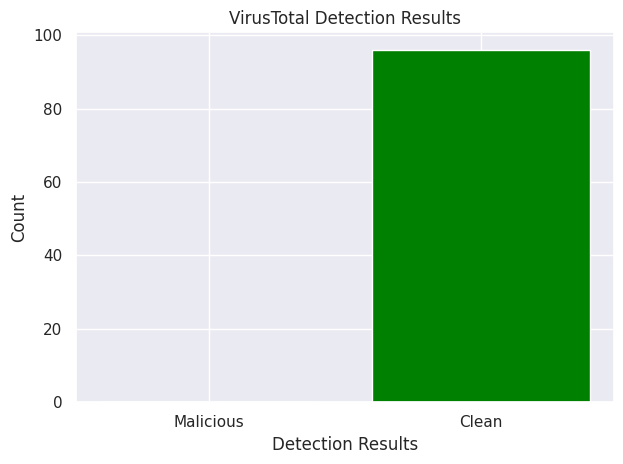


SSL Certificate: Valid
--------------------------------------------------


In [ ]:
!pip install whois
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import socket
import ssl
import whois
import matplotlib.pyplot as plt

# Predefined security vendors analysis data
security_vendors = {
    "Abusix": "Clean",
    "Acronis": "Clean",
    "ADMINUSLabs": "Clean",
    "AILabs (MONITORAPP)": "Clean",
    "AlienVault": "Clean",
    "alphaMountain.ai": "Clean",
    "Antiy-AVL": "Clean",
    "ArcSight Threat Intelligence": "Clean",
    "Artists Against 419": "Clean",
    "benkow.cc": "Clean",
    "Bfore.Ai PreCrime": "Clean",
    "BitDefender": "Clean",
    "BlockList": "Clean",
    "Blueliv": "Clean",
    "Certego": "Clean",
    "Chong Lua Dao": "Clean",
    "CINS Army": "Clean",
    "CMC Threat Intelligence": "Clean",
    "CRDF": "Clean",
    "Criminal IP": "Clean"
}

# Function to fetch domain information
def get_domain_info(url):
    domain = urlparse(url).netloc
    try:
        w = whois.whois(domain)
        print("\nDomain Information:")
        print(f"Domain Name: {w.domain_name}")
        print(f"Creation Date: {w.creation_date}")
        print(f"Expiration Date: {w.expiration_date}")
        print(f"Registrar: {w.registrar}")
    except Exception as e:
        print(f"Could not fetch domain info for {domain}: {str(e)}")

# Function to check against VirusTotal
def check_virustotal(url):
    vt_api_key = "35e7c261aaa87b7356968c3e3aa1fcb0b2e21a87258fda3bb957c6cc1a718850"  # Replace with your VirusTotal API key
    vt_url = f"https://www.virustotal.com/vtapi/v2/url/report?apikey={vt_api_key}&resource={url}"
    try:
        response = requests.get(vt_url)
        return response.json()  # Example of response handling
    except Exception as e:
        print(f"Could not check VirusTotal for {url}: {str(e)}")
        return None

# Function to plot VirusTotal results
def plot_virustotal_results(results):
    labels = ['Malicious', 'Clean']
    values = [results.get('positives', 0), results.get('total', 0) - results.get('positives', 0)]

    plt.bar(labels, values, color=['red', 'green'])
    plt.xlabel('Detection Results')
    plt.ylabel('Count')
    plt.title('VirusTotal Detection Results')
    plt.tight_layout()
    plt.show()

# Function to fetch detailed information about a URL
def analyze_website(url):
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        response = requests.get(url, allow_redirects=True, verify=False)
        soup = BeautifulSoup(response.text, 'html.parser')

        # HTTP Response Information
        print(f"\nAnalyzing: {url}")
        print(f"Final URL: {response.url}")
        print(f"Serving IP Address: {socket.gethostbyname(urlparse(response.url).hostname)}")
        print(f"Status code: {response.status_code}")
        print(f"Body length: {len(response.content) / 1024:.2f} KB")

        # Print headers
        print("\nHeaders:")
        for key, value in response.headers.items():
            print(f"{key.lower()}: {value}")

        # HTML Info
        print("\nHTML Info:")
        title = soup.title.string if soup.title else "No Title"
        print(f"Title: {title}")

        # Meta Tags
        print("\nMeta Tags:")
        for meta in soup.find_all('meta'):
            if meta.get('name'):
                print(f"{meta.get('name')}: {meta.get('content')}")

        # Security vendors analysis
        print("\nSecurity Vendors' Analysis:")
        for vendor, result in security_vendors.items():
            print(f"{vendor}: {result}")

        # Domain Info
        get_domain_info(url)

        # VirusTotal Check
        vt_results = check_virustotal(url)
        if vt_results:
            plot_virustotal_results(vt_results)

        # SSL Certificate details
        if url.startswith('https://'):
            try:
                hostname = urlparse(response.url).hostname
                context = ssl.create_default_context()
                with socket.create_connection((hostname, 443)) as conn:
                    with context.wrap_socket(conn, server_hostname=hostname) as ssl_conn:
                        ssl_info = ssl_conn.getpeercert()
                        print("\nSSL Certificate: Valid")
            except Exception as ssl_error:
                print("\nSSL Certificate: Invalid or Not Available")

    except requests.exceptions.RequestException as e:
        print(f"Failed to analyze {url}: {str(e)}")

# Example usage
websites_to_analyze = [
    "https://www.google.com"
]

for website in websites_to_analyze:
    analyze_website(website)
    print("-" * 50)